# 猫狗大战毕业项目

数据集
[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

### 1. 数据预处理
#### 1.1 利用keras的`ImageDataGenerator` 函数进行统一的预处理，生成批次的带实时数据增益的张量图像数据, `ImageDataGenerator` 需要将不同类别的图片分类后放置到相同的目录内；这里准备使用创建文件软链接的方式来分类文件

In [152]:
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
import os
import shutil

CUR_PATH = os.getcwd()
ORG_TRAIN_DIR = CUR_PATH +'/all/train/'
ORG_TEST_DIR = CUR_PATH + '/all/test/'
TRAIN_DIR = CUR_PATH + "/input/train"
TRAIN_CAT_DIR = TRAIN_DIR + "/cat/"
TRAIN_DOG_DIR = TRAIN_DIR + "/dog/"
TEST_DIR = CUR_PATH + "/input/test"
LR = 1e-3

def sort_img(dir_path):
    '''判断图片是猫还是狗'''
    train_filenames = os.listdir(dir_path)
#     print(train_filenames)
    train_cat = list(filter(lambda x:x.split('.')[0] == 'cat', train_filenames))
    train_dog = list(filter(lambda x:x.split('.')[0] == 'dog', train_filenames))
    return train_cat , train_dog

def create_dir(dir_path):
    '''建立指定的目录'''
    remove_dir(dir_path)
    os.makedirs(dir_path,exist_ok=True)

def remove_dir(dir_path):
    if os.path.exists(dir_path):
        if os.path.isdir(dir_path):
            shutil.rmtree(dir_path)
        elif os.path.isfile(dir_path):
            os.remove(dir_path)
        elif os.path.is_symlink(dir_path):
            os.unlink(dir_path)

def process_train_data(data_list, org_path, tar_path):
    '''建立分猫狗分类目录及软链接'''
    create_dir(tar_path)
    
    for img in tqdm(data_list):
        os.symlink(org_path + img,tar_path + img)


In [153]:
# cat, dog = sort_img(ORG_TRAIN_DIR) #分别建立猫狗数据
process_train_data(cat,ORG_TRAIN_DIR,TRAIN_CAT_DIR) 
process_train_data(dog,ORG_TRAIN_DIR,TRAIN_DOG_DIR)

if os.path.exists(TEST_DIR) :
    os.unlink(TEST_DIR)
os.symlink(ORG_TEST_DIR,TEST_DIR,target_is_directory=True)

100%|██████████| 12500/12500 [00:00<00:00, 14812.99it/s]


#### 1.2 数据探索

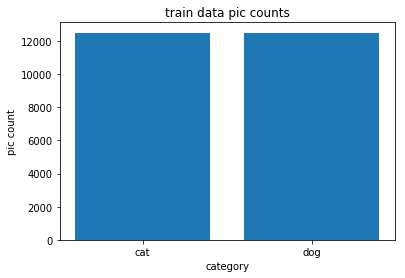

In [96]:
import numpy as np
import matplotlib.pyplot as plt

x =np.array([len(cat),len(dog)])
plt.bar(['cat','dog'],[x[0],x[1]])
plt.xlabel('category')
plt.ylabel('pic count')
plt.title('train data pic counts')
plt.show()

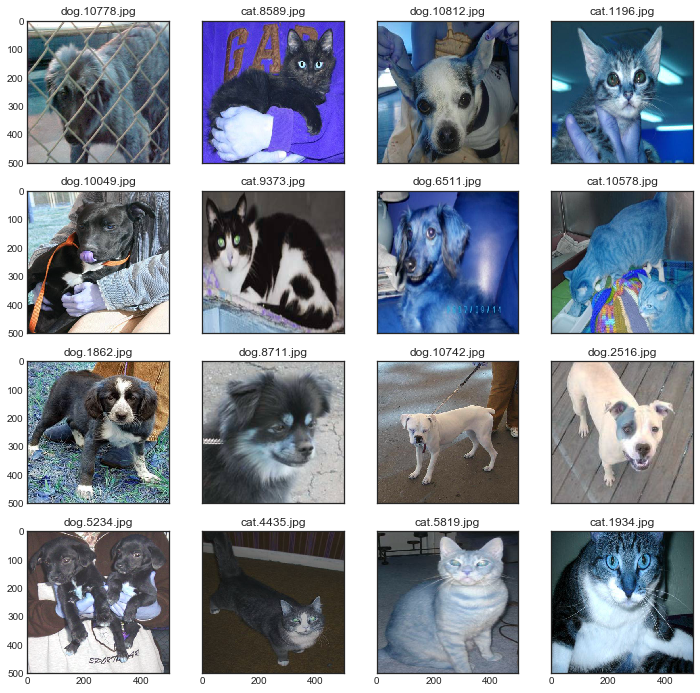

In [104]:
import random
import cv2

#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))
train_filenames = os.listdir(ORG_TRAIN_DIR)
#随机获取图片
for i in range(4):
    for j in range(4):
        ran = random.randint(0,len(train_filenames))
        img = cv2.imread(ORG_TRAIN_DIR + train_filenames[ran])
        img = cv2.resize(img, (500,500))
        ax[i,j].set_title('%s'% train_filenames[ran])
        ax[i,j].imshow(img)

### 2 导出特征向量

keras的提供了可选的模型

模型|	大小|	Top-1 准确率	|Top-5准确率|	参数数量|	深度
----|---|---|---|---|---
Xception	|88 MB	|0.790	|0.945|	22,910,480	|126
VGG16	|528 MB	|0.715	|0.901	|138,357,544	|23
VGG19	|549 MB	|0.727|	0.910	|143,667,240	|26
ResNet50|	99 MB	|0.759	|0.929	|25,636,712|168
InceptionV3	|92 MB|	0.788|	0.944	|23,851,784|	159
InceptionResNetV2|	215 MB	|0.804	|0.953	|55,873,736|	572
MobileNet	|17 MB|	0.665|	0.871|	4,253,864	|88
DenseNet121	|33 MB	|0.745|	0.918	|8,062,504	|121
DenseNet169	|57 MB|	0.759	|0.928|	14,307,880	|169
DenseNet201	|80 MB|	0.770|	0.933	|20,242,984	|201

这里只使用 InceptionV3、ResNet50 和 Xception 这三个模型。

In [105]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(TRAIN_DIR, image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory(TEST_DIR, image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)


Using TensorFlow backend.
/Users/wangye/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


 3956736/94653016 [>.............................] - ETA: 2:02

KeyboardInterrupt: 